### Содержание

1. [Получение и предобработка данных](#chapter1)
2. [Выборочные характеристики временных рядов](#chapter2)
3. [Расчет Value at Risk](#chapter3)
4. [Оценка EAR](#chapter4)
5. [Оценка RAROC](#chapter5)

### 1. Получение и предобработка данных. <a class="anchor" id="chapter1"></a>

In [1]:
import numpy as np
import pandas as pd
import arch
import apimoex
import requests
from scipy import stats
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

Для начала нам нужно получить данные с Мосбиржи для каких-нибудь двух акций. Выберем ликвидные - скажем, Сбер и Магнит. Получим текущую дату, чтобы знать, начиная с какой даты выгружать данные.

In [2]:
print(f'Текущая дата: {datetime.now():%Y-%m-%d}')

Текущая дата: 2021-09-17


In [3]:
with requests.Session() as session:
    sber, mgnt = [apimoex.get_board_history(session, x, start='2016-09-17') \
                  for x in  ['SBER', 'MGNT']]
    sber, mgnt = pd.DataFrame(sber), pd.DataFrame(mgnt)
    sber.set_index('TRADEDATE', inplace=True)
    mgnt.set_index('TRADEDATE', inplace=True)
    sber.index = pd.to_datetime(sber.index, format='%Y-%m-%d')
    mgnt.index = pd.to_datetime(sber.index, format='%Y-%m-%d')

In [4]:
sber.head()

,BOARDID,CLOSE,VOLUME,VALUE
TRADEDATE,,,,
2016-09-19,TQBR,148.66,38986370,5.808871e+09
2016-09-20,TQBR,149.30,35197210,5.213689e+09
2016-09-21,TQBR,150.67,43825610,6.611184e+09
2016-09-22,TQBR,154.18,66192510,1.013190e+10
2016-09-23,TQBR,151.50,51201870,7.765907e+09


Немного поработаем с табличкой.

In [5]:
sber.rename(columns={'CLOSE': 'sber', 'VOLUME':'sber_volume'}, inplace=True)
mgnt.rename(columns={'CLOSE': 'mgnt', 'VOLUME':'mgnt_volume'}, inplace=True)

Теперь считаем данные по золоту и EURUSD. Данные были получены из терминала Thomson Reuters Eikon.

In [6]:
data = pd.read_csv('./data.csv', parse_dates=True, index_col='TRADEDATE')
data.head()

,gold,eurusd
TRADEDATE,,
2016-09-13,1318.6100,1.1217
2016-09-14,1322.6000,1.1249
2016-09-15,1313.8000,1.1241
2016-09-16,1310.0601,1.1153
2016-09-19,1313.2200,1.1173


Объединим все датасеты в один.

In [7]:
df = pd.merge(left=pd.merge(left=sber['sber'], 
                   right=mgnt['mgnt'], 
                   left_index=True, right_index=True, sort=True),
              right=data,
              left_index=True,
              right_index=True)
              

df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

df.head(5)

,sber,mgnt,gold,eurusd
TRADEDATE,,,,
2016-09-19,148.66,10339.0,1313.22,1.1173
2016-09-20,149.30,10350.0,1314.60,1.1152
2016-09-21,150.67,10648.0,1336.45,1.1185
2016-09-22,154.18,10700.0,1336.67,1.1207
2016-09-23,151.50,10600.0,1337.21,1.1222


Теперь можно и нарисовать динамику инструментов.

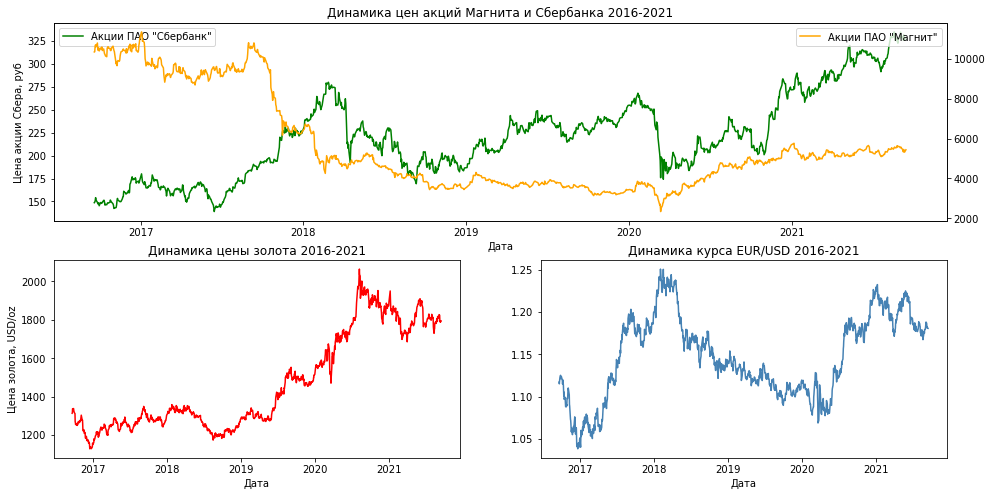

In [8]:
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = ax.twinx()

ax.plot(df.index, df.sber, color='green', label='Акции ПАО "Сбербанк"')
ax2.plot(df.index, df.mgnt, color='orange', label='Акции ПАО "Магнит"')

ax.set_xlabel('Дата')
ax.set_ylabel('Цена акции Сбера, руб')
ax.set_title('Динамика цен акций Магнита и Сбербанка 2016-2021')
ax.legend()
ax2.legend()

ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3.plot(df.index, df.gold, color='red')
ax3.set_xlabel('Дата')
ax3.set_ylabel('Цена золота, USD/oz')
ax3.set_title('Динамика цены золота 2016-2021')

ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax4.plot(df.index, df.eurusd, color='steelblue')
ax4.set_xlabel('Дата')
ax4.set_title('Динамика курса EUR/USD 2016-2021')

plt.show();

Что можно сказать по графику?
1. **Сбербанк**, будучи крупнейшим банком, всегда наращивал капитализацию. Его котировки несколько просели в начале пандемии, но потом продемонстрировали мощный рост. Во многом благодаря 
   * Сильным, несмотря на пандемию, финансовым результатам
   * Вере инвесторов в то, что Сбер сумел построить экосистему
   
   
2. **Магнит** до 2020 падал. В 2020 году благодаря смене руководства компания сумела:
   * Воспользоваться паникой на фоне угрозы введения карантина и показать мощный рост продаж летом 2020 года.
   * Существенно нарастить EBITDA маржу, увеличить эффективность управления оборотным капиталом и долю рынка.

Благодаря сделке по покупке сети магазинов "Дикси", "Магнит" по доле рынка и финансовым показателям почти догнал лидера продовольственного ритейла в России - X5 Retail Group, что и отражено в динамике котировок за последний год.

3. **Золото** находилось в боковике до начала коронавируса в связи со сворачиванием программы количественного смягчения. В 2020-2021 годах золото поддержали:
   * Пандемия и мировой экономический кризис
   * Мощная программа количественного смягчения
   * Резкий рост инфляции в 2021 году
   
   
4. **EUR/USD** падал в 2017-2018 на фоне замедления роста европейской экономики (ВВП лидеров ЕС рос медленно, не удавалось достигнуть таргет по инфляции, несмотря на отрицательные ставки). Медленное восстановление экономики еврозоны после пандемии снова ударило по евро.

### 2. Выборочные характеристики временных рядов <a class="anchor" id="chapter2"></a>

Далее мы будем работать с лог-доходностями акций, поскольку они, в отличие от цен, являются стационарными с гораздо большей вероятностью, а также имеют удобную интерпретацию в терминах Value at Risk. Логарифм доходности  по формуле Тейлора приблизительно равен самой доходности, в слаучае, если изменение цены сравнительно мало.

In [9]:
r = np.log(1+df.pct_change()).iloc[1:, :]
print('Начало набора данных с доходностями')
r.head(5)

Начало набора данных с доходностями


,sber,mgnt,gold,eurusd
TRADEDATE,,,,
2016-09-20,0.004296,0.001063,0.001050,-0.001881
2016-09-21,0.009134,0.028386,0.016484,0.002955
2016-09-22,0.023029,0.004872,0.000165,0.001965
2016-09-23,-0.017535,-0.009390,0.000404,0.001338
2016-09-26,-0.015968,0.017673,0.000262,0.002759


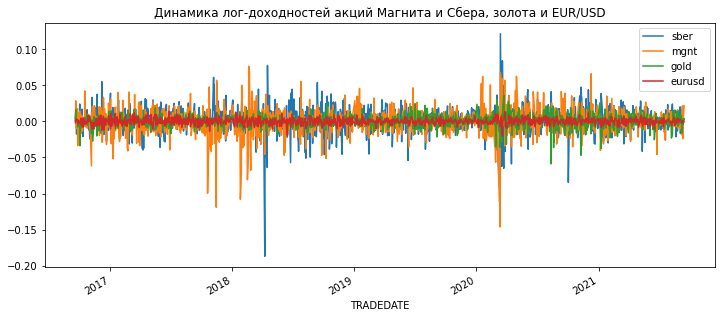

In [10]:
r.plot(title='Динамика лог-доходностей акций Магнита и Сбера, золота и EUR/USD',
       #xlabel='Дата',
       #ylabel='Доходность',
       legend=True,
       figsize=(12, 5));

Заметим, что волатильность лог-доходностей золота и валютного курса евро к доллару гораздо меньше, чем у российских акций. Это согласуется и с гистограммами распределений. Теперь посмотрим на распределения (индивидуальные и совместные) доходностей.

<Figure size 1008x720 with 0 Axes>

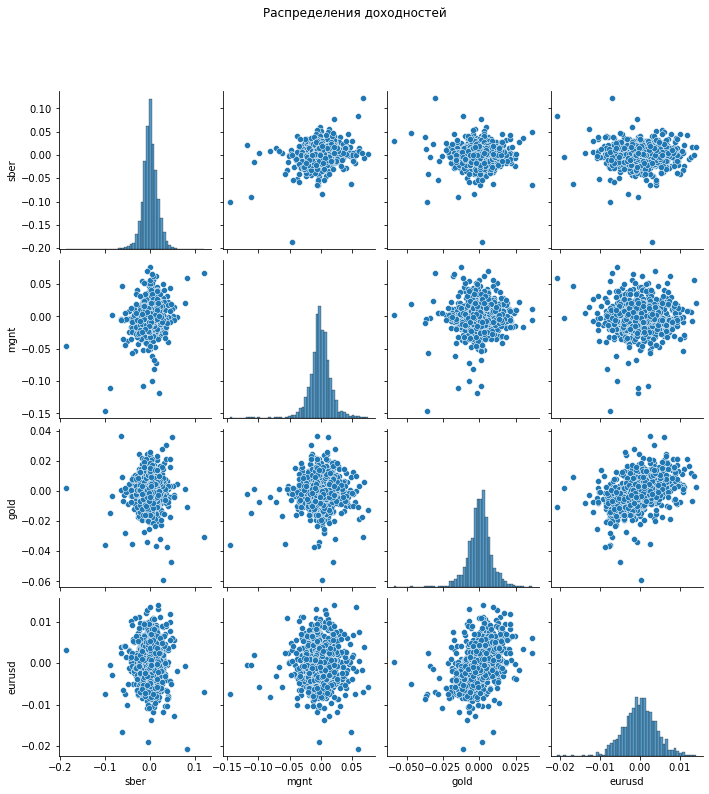

In [11]:
plt.figure(figsize=(14, 10));
g = sns.pairplot(r, diag_kws={'bins':50})
g.fig.suptitle('Распределения доходностей', y=1.1);

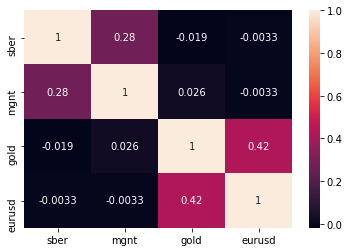

In [12]:
sns.heatmap(r.corr(), annot=True);

Между акциями и между EURUSD и золотом наблюдается умеренная корреляция. Все распределения явно не похожи на нормальные - гораздо более "островерхие", с более тяжелыми "хвостами". Исключение составляет EURUSD.

Последнее, что осталось - протестировать лог-доходности на нормальность.

In [26]:
def isNormal(returns: pd.Series, series_name:str):
    ks_crit = stats.kstest(returns,'norm')[0]
    ks_pval = stats.kstest(returns,'norm')[1]
    
    out = \
    f"""
    Временной ряд: {series_name}
    ----------
    Тестовая статистика Шапиро: {stats.shapiro(returns)[0]:.3f},
    p-value: {stats.shapiro(returns)[1]:.3f} \n
    Тестовая статистика Колмогорова-Смирнова: {ks_crit:.3f}, 
    p-value: {ks_pval:.3f}"""
    return out

In [27]:
r.apply(lambda x: print(isNormal(x, x.name)))


    Временной ряд: sber
    ----------
    Тестовая статистика Шапиро: 0.917,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.475, 
    p-value: 0.000

    Временной ряд: mgnt
    ----------
    Тестовая статистика Шапиро: 0.915,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.472, 
    p-value: 0.000

    Временной ряд: gold
    ----------
    Тестовая статистика Шапиро: 0.948,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.487, 
    p-value: 0.000

    Временной ряд: eurusd
    ----------
    Тестовая статистика Шапиро: 0.993,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.494, 
    p-value: 0.000


sber      None
mgnt      None
gold      None
eurusd    None
dtype: object

Таким образом, распределения всех доходностей не нормальны, а значит, нормальное распределение лучше не использовать при расчете Value at Risk.

### 3. Расчет Value at Risk. <a class="anchor" id="chapter3"></a>
#### Исторический метод.
Сначала оценим Value at Risk историческим методом. Будем считать, что дневная доходность каждого из инструментов в среднем равна нулю.

In [28]:
print('Средние дневные доходности инструментов:')
r.mean()

Средние дневные доходности инструментов:


sber      0.000631
mgnt     -0.000514
gold      0.000249
eurusd    0.000044
dtype: float64

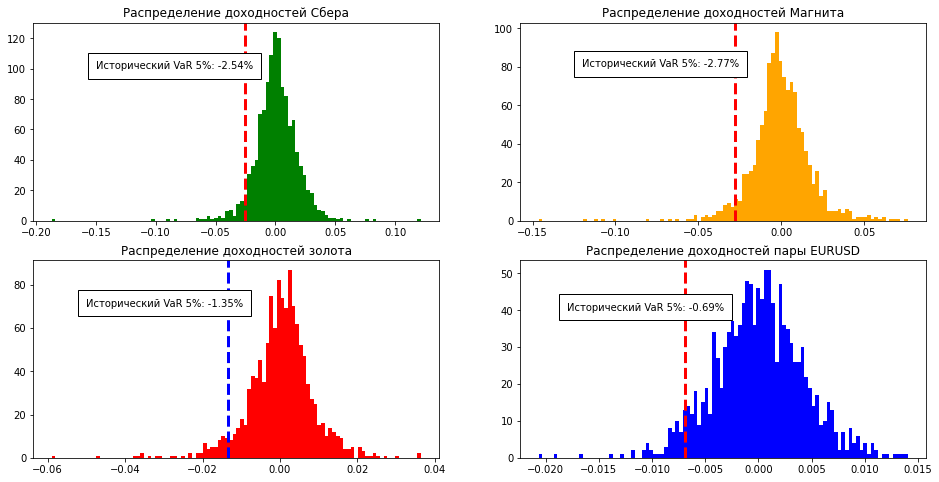

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

ax[0,0].hist(r.sber, color='green', bins=100)
ax[0,0].set_title('Распределение доходностей Сбера')
ax[0,0].axvline(x=np.quantile(a=r.sber, q=0.05), 
              color='red', linewidth=3, linestyle='--')
ax[0,0].text(-0.15, 100, 
           f'Исторический VaR 5%: {np.quantile(a=r.sber, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

ax[0,1].hist(r.mgnt, color='orange', bins=100)
ax[0,1].set_title('Распределение доходностей Магнита')
ax[0,1].axvline(x=np.quantile(a=r.mgnt, q=0.05), 
              color='red', linewidth=3, linestyle='--')
ax[0,1].text(-0.12, 80, 
           f'Исторический VaR 5%: {np.quantile(a=r.mgnt, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

ax[1, 0].hist(r.gold, color='red', bins=100)
ax[1, 0].set_title('Распределение доходностей золота')
ax[1, 0].axvline(x=np.quantile(a=r.gold, q=0.05), 
              color='blue', linewidth=3, linestyle='--')
ax[1,0].text(-0.05, 70, 
           f'Исторический VaR 5%: {np.quantile(a=r.gold, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

ax[1,1].hist(r.eurusd, color='blue', bins=100)
ax[1,1].set_title('Распределение доходностей пары EURUSD')
ax[1,1].axvline(x=np.quantile(a=r.eurusd, q=0.05), 
             color='red', linewidth=3, linestyle='--')
ax[1,1].text(-0.018, 40, 
           f'Исторический VaR 5%: {np.quantile(a=r.eurusd, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

plt.show();

Посмотрим на динамику исторического VaR. Будем использовать скользящее окно в 126 дней. Почему именно такое окно?
1. Российский фондовый рынок волатилен, использование окна в месяц или квартал может привести к некорректной оценке риска. 
2. В то же время, использование слишком "длинного" окна (торговый год) может также привести к некорректной оценке риска в связи с изменениями, произошедшими на рынке.

Исходя из этого, оптимальное окно - торговое полугодие (126 дней). При расчете будем сдвигать эмпирический квантиль на 1 период вперед (`shift=1`), поскольку мы делаем прогноз для следующего торгового дня.

In [30]:
sber_hvar5 = r.sber.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)
mgnt_hvar5 = r.mgnt.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)

gold_hvar5 = r.gold.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)
eurusd_hvar5 = r.eurusd.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)

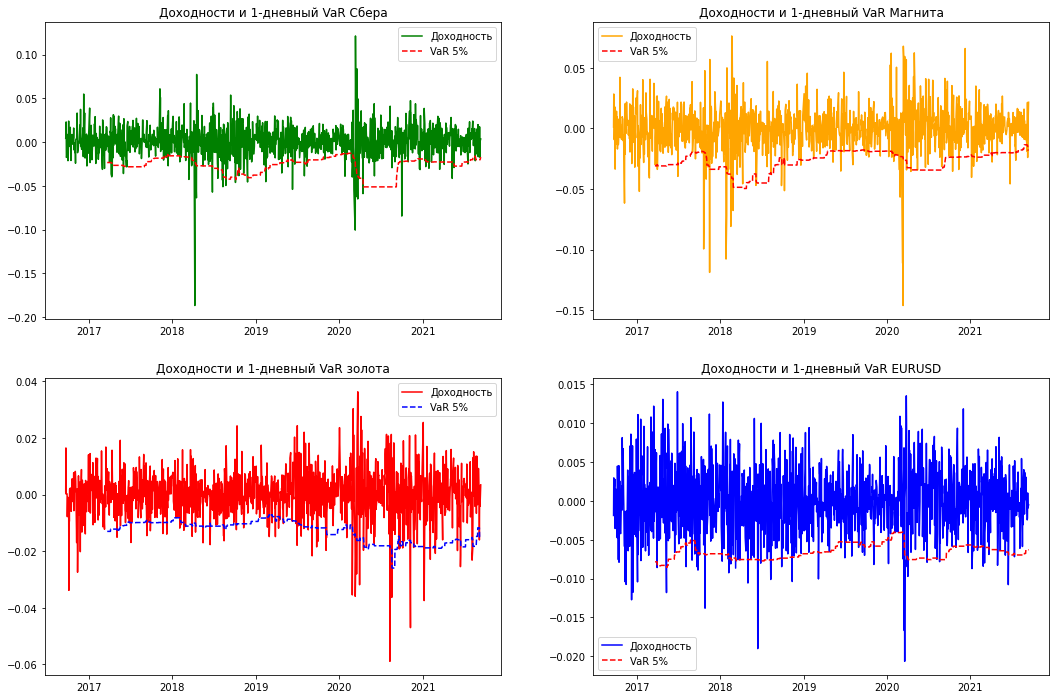

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax[0,0].plot(r.sber, color='green', label='Доходность')
ax[0,0].plot(sber_hvar5, color='red', label='VaR 5%', linestyle='--')
ax[0,0].set_title('Доходности и 1-дневный VaR Сбера')
ax[0,0].legend()

ax[0,1].plot(r.mgnt, color='orange', label='Доходность')
ax[0,1].plot(mgnt_hvar5, color='red', label='VaR 5%', linestyle='--')
ax[0,1].set_title('Доходности и 1-дневный VaR Магнита')
ax[0,1].legend()

ax[1,0].plot(r.gold, color='red', label='Доходность')
ax[1,0].plot(gold_hvar5, color='blue', label='VaR 5%', linestyle='--')
ax[1,0].set_title('Доходности и 1-дневный VaR золота')
ax[1,0].legend()

ax[1,1].plot(r.eurusd, color='blue', label='Доходность')
ax[1,1].plot(eurusd_hvar5, color='red', label='VaR 5%', linestyle='--')
ax[1,1].set_title('Доходности и 1-дневный VaR EURUSD')
ax[1,1].legend()

plt.show();

На графике сразу видны недостатки исторического подхода: 
* Если на рынке был шок, такой подход будет завышать риск уже после того, как рынок "устаканится". Особенно это заметно в 2020 году.
* Такая простая модель не сможет уловить тренд, если волатильность возрастает или снижается.

#### Параметрический метод.

Традиционный и достаточно эффективный подход - использование GARCH(p, q) моделей для описания волатильности доходностей. Модель GARCH(1, 1) можно описать следующим образом:

$$
r_t = \mu + \epsilon_t \\
\sigma^{2}_{t} = \omega + \alpha\epsilon^{2}_{t_1}+ \beta\sigma^{2}_{t_1} \\
\epsilon_t = \sigma_t\varepsilon_t, \ \varepsilon_t \sim N(0,1) \\
$$

Зачастую для достаточно точной спецификации GARCH-модели достаточно одного лага $p$ и одного лага $q$, дальнейшее усложнение модели ведет лишь к излишней параметризации.

Зададим функцию для оценки GARCH-модели и построения прогноза стандартного отклонения доходностей на основе кода библиотеки `arch`. Параметры модели:
* $p$ =1, $q$ = 1
* в модель волатильности включена константа $\omega$
* Случайные шоки $\varepsilon$ распределены по Стьюденту - это более реалистичная предпосылка, чем нормальное распределение, если отталкиваться от графиков эмпирического распределения.

In [33]:
garch_kwargs = {'p':1, 'q':1, 
                'mean':'constant', 
                'vol':'GARCH', 'dist':'studentst'} 

In [34]:
def GARCH_fitpredict(series, horizon, **garch_kwargs):
    """
    Returns GARHC conditional volatility forecast for given series
    -----------
    Parameters:
    series - series of returns
    horizon - number of periods to forecast std
    garch_kwargs - GARCH params such as p, q, mean, vol type and error distribution
    """
    model = arch.arch_model(series*100, **garch_kwargs)
    # turn off printing estimation results
    fitted = model.fit(disp='off')
    forecast = fitted.forecast(horizon=horizon, 
                               start=series.index[-1], 
                               reindex=True)
    std_forecast = np.sqrt(forecast.variance.iloc[-1, :].values/10**4)
    if horizon==1:
        return std_forecast[0]
    return std_forecast

Также для получения Value at Risk нам нужно будет умножить прогноз волатильности, полученный по модели GARCH, на квантиль нормального (или Стьюдента) распределения.

In [35]:
# 5% и 95% квантили для нормального распределения 
stats.norm.ppf((0.05, 0.95))

array([-1.64485363,  1.64485363])

In [36]:
def VaR(returns: pd.Series,
        method: str,
        level,
        ret_dist:str,
        garch_kwargs=None):
    """
    Returns Value at Risk for given asset returns
    ----
    Parameters:
    - method: str, historical or parametric
    - level: float in (0, 1), VaR level
    - rets: error distribution in GARCH model, 'norm' or 't' (Student)
    - garch_kwargs: GARCH model parameters for GARCH_fitpredict
    """
    
    # historical VaR calculation
    if method=='historic':
        return np.quantile(returns, level)
    # parametric VaR with GARCH forecast
    elif method=='parametric':
        # fit Student distribution to returns
        if ret_dist=='t':
            t_df, t_loc, t_scale = stats.t.fit(returns)
            crit_value = stats.t(df=t_df).ppf(level)
        else:
            crit_value = stats.norm.ppf(level)
        return crit_value * GARCH_fitpredict(returns, 
                                             horizon=1,
                                             **garch_kwargs)

Попробуем прогнать параметрический VaR на исторических данных акций. Снова `shift=1`, чтобы прогнозировать на один период вперед.
Параметры VaR:
* Окно (размер выборки для оценки GARCH(1,1) - 126 торговых дней 
* Распределение доходностей - нормальное 

Сначала создадим словарь, куда положим все комбинации параметров для оценки Value at Risk, потому что их у нас набралось уже довольно много.

In [44]:
VaR_kwargs = {x :{'method': 'parametric',
                  'level': 0.05,
                  'ret_dist': 'norm',
                  'garch_kwargs': garch_kwargs} for x in ['sber_5%',
                                                          'mgnt_5%',
                                                          'gold_5%',
                                                          'eurusd_5%']}

Теперь оценим сам Value at Risk. Поскольку мы оцениваем около 8 тысяч моделей GARCH в цикле, это может занять некоторое время.

**Внимание! Эту ячейку кода лучше просто так не запускать, на старом или маломощном компьютере она будет считаться долго.**

In [45]:
%%time
sber_pvar5 = r.sber.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['sber_5%'])).shift(1)
mgnt_pvar5 = r.mgnt.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['mgnt_5%'])).shift(1)

gold_pvar5 = r.gold.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['gold_5%'])).shift(1)
eurusd_pvar5 = r.eurusd.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['eurusd_5%'])).shift(1)

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09953. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09876. Parameter
estimation work better when this value is between 1 and 1000

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: D

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09578. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09509. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: D

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: Da

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0914. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: Da

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0892. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: Da

C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Vladimir\anaconda3\lib\site-packages\arch\univariate\base.py:309: Dat

Wall time: 2min 41s


На моем компьютере оценка заняла три минуты.

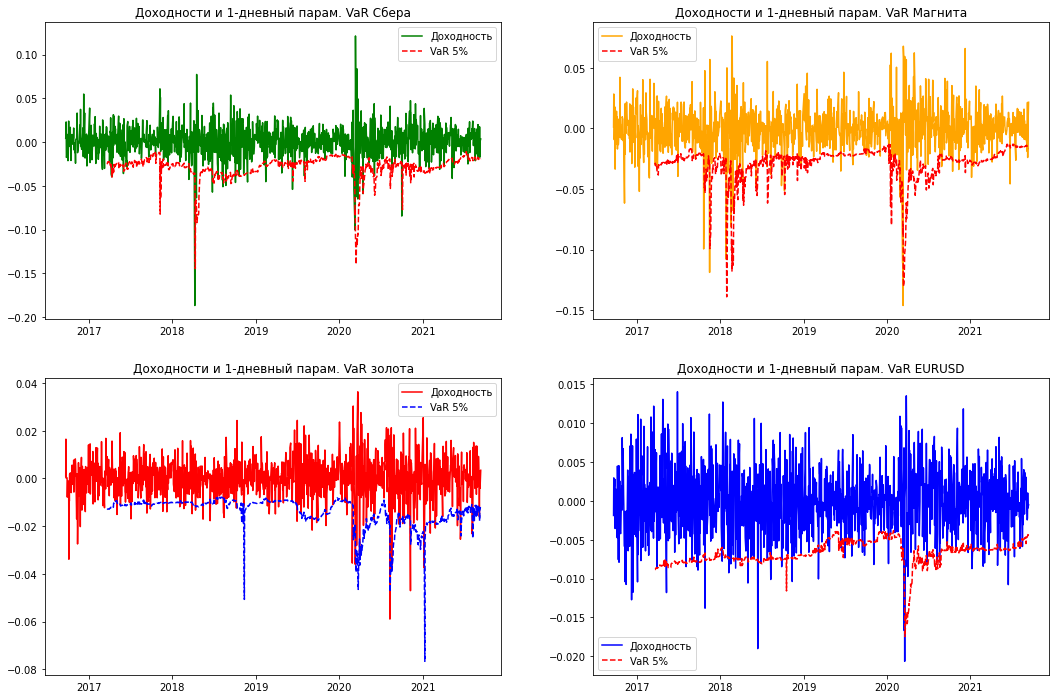

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax[0,0].plot(r.sber, color='green', label='Доходность')
ax[0,0].plot(sber_pvar5, color='red', label='VaR 5%', linestyle='--')
ax[0,0].set_title('Доходности и 1-дневный парам. VaR Сбера')
ax[0,0].legend()

ax[0,1].plot(r.mgnt, color='orange', label='Доходность')
ax[0,1].plot(mgnt_pvar5, color='red', label='VaR 5%', linestyle='--')
ax[0,1].set_title('Доходности и 1-дневный парам. VaR Магнита')
ax[0,1].legend()

ax[1,0].plot(r.gold, color='red', label='Доходность')
ax[1,0].plot(gold_pvar5, color='blue', label='VaR 5%', linestyle='--')
ax[1,0].set_title('Доходности и 1-дневный парам. VaR золота')
ax[1,0].legend()

ax[1,1].plot(r.eurusd, color='blue', label='Доходность')
ax[1,1].plot(eurusd_pvar5, color='red', label='VaR 5%', linestyle='--')
ax[1,1].set_title('Доходности и 1-дневный парам. VaR EURUSD')
ax[1,1].legend()

plt.show();

Мы сразу видим, что параметрическая модель гораздо лучше подстраивается под краткосрочные тренды волатильности. Но на линейный график в данной ситуации смотреть не очень удобно, "пробития" VaR гораздо лучше видны на точечном графике:

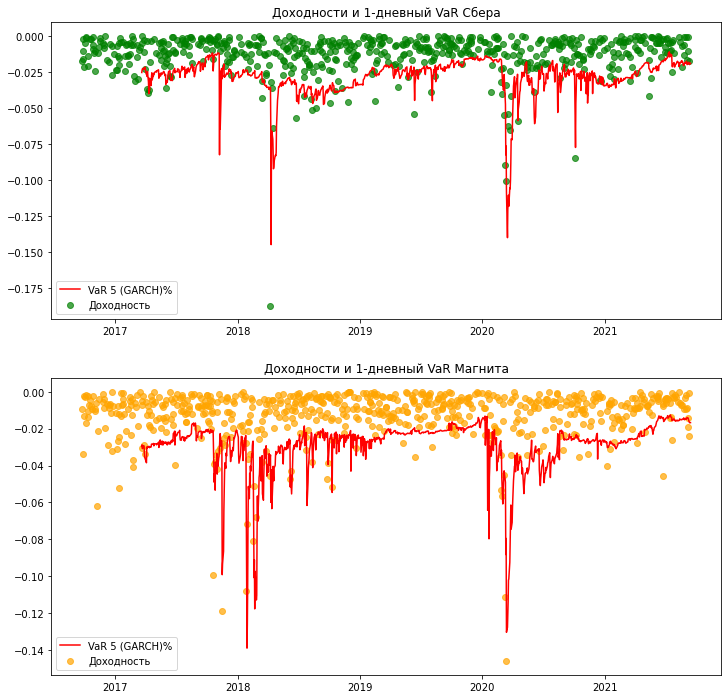

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

ax[0].scatter(r.sber[r.sber<=0].index, r.sber[r.sber<=0].values, 
              color='green', label='Доходность', alpha=0.7)
ax[0].plot(sber_pvar5, color='red', label='VaR 5 (GARCH)%')
ax[0].set_title('Доходности и 1-дневный VaR Сбера')
ax[0].legend()

ax[1].scatter(r.mgnt[r.mgnt<=0].index, r.mgnt[r.mgnt<=0].values,
              color='orange', label='Доходность', alpha=0.7)
ax[1].plot(mgnt_pvar5, color='red', label='VaR 5 (GARCH)%')
ax[1].set_title('Доходности и 1-дневный VaR Магнита')
ax[1].legend()

plt.show();

Лучше всего видна разница между историческим и параметрическим методом, если "увеличить масштаб" графика. Посмотрим, например, только на 2020 год.

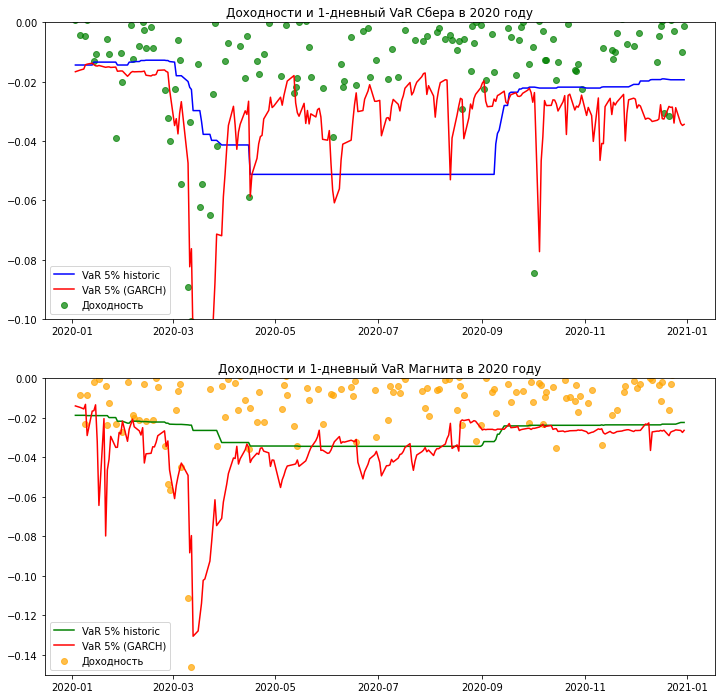

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

ax[0].scatter(r.sber['2020'].index, r.sber['2020'].values, 
              color='green', label='Доходность', alpha=0.7)
ax[0].plot(sber_hvar5['2020'], color='blue', label='VaR 5% historic')
ax[0].plot(sber_pvar5['2020'], color='red', label='VaR 5% (GARCH)')
ax[0].set_title('Доходности и 1-дневный VaR Сбера в 2020 году')
ax[0].set_ylim([-0.1, 0])
ax[0].legend()

ax[1].scatter(r.mgnt['2020'].index, r.mgnt['2020'].values,
              color='orange', label='Доходность', alpha=0.7)
ax[1].plot(mgnt_hvar5['2020'], color='green', label='VaR 5% historic')
ax[1].plot(mgnt_pvar5['2020'], color='red', label='VaR 5% (GARCH)')
ax[1].set_title('Доходности и 1-дневный VaR Магнита в 2020 году')
ax[1].set_ylim([-0.15, 0])
ax[1].legend()

plt.show();

Для проверки корректной работы модели необходим статистический тест. Воспользуемся тестом Купика. Его нулевая гипотеза - число пробитий (когда доходность меньше VaR) равно ожидаемому (уровень VaR умножить на количество наблюдений в выборке).

In [49]:
def kupiec_test(returns, var, series_name:str, conflevel=0.05):
    """
    Parameters:
    - returns: series of returns
    - var: series of Value at Risk estimates
    - conflevel: VaR level
    """
    L = len(returns)
    K = sum(returns < var)
    a0 = K/L
    S = 2*np.log( ((1-a0)**(L-K)) * (a0**K) ) - 2*np.log( ((1-conflevel)**(L-K)) * (conflevel**K) )
    pval = 1 - stats.chi2.cdf(S, df=1) # distribution function
    print(
    f"""
    Тест Купика для {series_name}. 
    H_0: число пробитий VaR соответствует ожидаемому.
    Уровень доверия: {conflevel*100:.0f}%.
    ---------------------------------------
    Доля пробитий VaR в выборке: {a0:.3f}
    Ожидаемая доля пробитий: {conflevel:.3f}
    P-value тестовой статистики: {pval:.2f}
    ---------------------------------------
    """)

In [50]:
kupiec_test(r.sber, sber_pvar5, series_name='VaR акций Сбера', conflevel=0.05)
kupiec_test(r.mgnt, mgnt_pvar5, series_name='VaR акций Магнита', conflevel=0.05)
kupiec_test(r.gold, gold_pvar5, series_name='VaR золота', conflevel=0.05)
kupiec_test(r.eurusd, eurusd_pvar5, series_name='VaR EURUSD', conflevel=0.05)


    Тест Купика для VaR акций Сбера. 
    H_0: число пробитий VaR соответствует ожидаемому.
    Уровень доверия: 5%.
    ---------------------------------------
    Доля пробитий VaR в выборке: 0.038
    Ожидаемая доля пробитий: 0.050
    P-value тестовой статистики: 0.03
    ---------------------------------------
    

    Тест Купика для VaR акций Магнита. 
    H_0: число пробитий VaR соответствует ожидаемому.
    Уровень доверия: 5%.
    ---------------------------------------
    Доля пробитий VaR в выборке: 0.047
    Ожидаемая доля пробитий: 0.050
    P-value тестовой статистики: 0.64
    ---------------------------------------
    

    Тест Купика для VaR золота. 
    H_0: число пробитий VaR соответствует ожидаемому.
    Уровень доверия: 5%.
    ---------------------------------------
    Доля пробитий VaR в выборке: 0.046
    Ожидаемая доля пробитий: 0.050
    P-value тестовой статистики: 0.55
    ---------------------------------------
    

    Тест Купика для VaR EURUSD. 


Наша модель прошла тест для 5% VaR для всех рядов, кроме Сбера. Причина - для 5% VaR мы наблюдаем пробития почти в 4% наблюдений, для которых VaR был спрогнозирован параметрическим методом. Иначе говоря, модель серьезно переоценивает риск для 5% VaR.

Добавим к датафрейму с доходностями VaRы.

In [51]:
r['sber_VaR_5_param'] = sber_pvar5
r['mgnt_VaR_5_param'] = mgnt_pvar5
r['sber_VaR_5_hist'] = sber_hvar5
r['mgnt_VaR_5_hist'] = mgnt_hvar5
r['gold_VaR_5_param'] = gold_pvar5
r['eurusd_VaR_5_param'] = eurusd_pvar5
r['gold_VaR_5_hist'] = gold_hvar5
r['eurusd_VaR_5_hist'] = eurusd_hvar5

### 4. Оценка EAR <a class="anchor" id="chapter4"></a>

Теперь оценим на скользящем окне в торговые полгода RORAC, EAR (историческим и параметрическим методом), добавим оценки метрик к датафрейму с доходностями.

In [52]:
def ear(series:pd.Series, type='historic'):
    """Returns Earnings at Risk for given asset returns"""
    if type=='historic':
        return series[series<0].median()
    # parametric approach
    return series[series<0].mean()

In [53]:
r['sber_ear_hist'] = r.sber.rolling(window=126).apply(lambda x: ear(x))
r['mgnt_ear_hist'] = r.mgnt.rolling(window=126).apply(lambda x: ear(x))
r['sber_ear_param'] = r.sber.rolling(window=126).apply(lambda x: ear(x, 'parametric'))
r['mgnt_ear_param'] = r.mgnt.rolling(window=126).apply(lambda x: ear(x, 'parametric'))
r['gold_ear_hist'] = r.gold.rolling(window=126).apply(lambda x: ear(x))
r['eurusd_ear_hist'] = r.eurusd.rolling(window=126).apply(lambda x: ear(x))
r['gold_ear_param'] = r.gold.rolling(window=126).apply(lambda x: ear(x, 'parametric'))
r['eurusd_ear_param'] = r.eurusd.rolling(window=126).apply(lambda x: ear(x, 'parametric'))

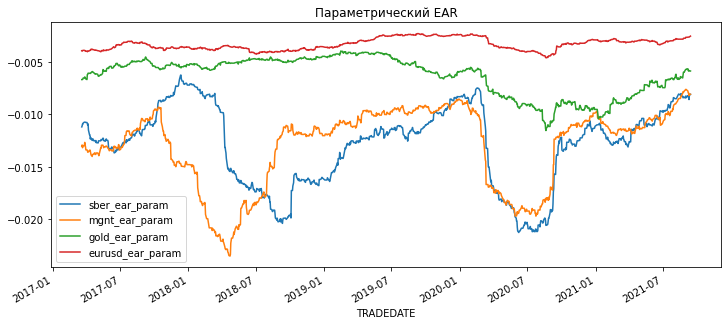

In [54]:
ear_p_cols = [x for x in r.columns if 'ear_param' in x]
r[ear_p_cols].plot(figsize=(12, 5), title='Параметрический EAR');

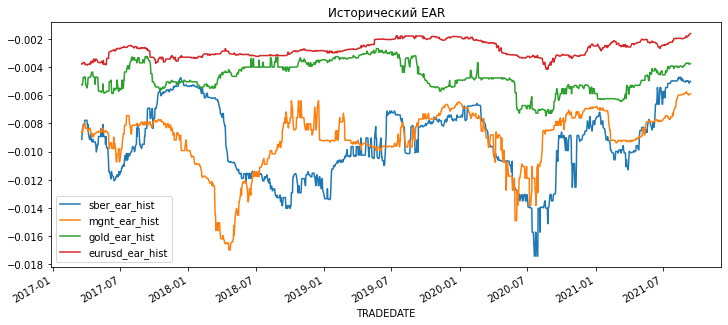

In [55]:
ear_h_cols = [x for x in r.columns if 'ear_hist' in x]
r[ear_h_cols].plot(figsize=(12, 5), title='Исторический EAR');

EAR, расчитанные историческим и параметрическим методом, отличаются несильно. Заметно, что исторический подход более нестабилен. Опять же, российские акции снова рискованнее, чем золото и валютная пара - последние гораздо более ликвидны, у их распределений в принципе меньше разброс, что подтверждают и гистограммы распределений.

### 5. Оценка RAROC. <a class="anchor" id="chapter5"></a>

Собственно все, осталось только посчитать RORAC.

In [56]:
r['sber_raroc_hist'] = (r.sber-r.sber_ear_hist)/r.sber_VaR_5_hist
r['mgnt_raroc_hist'] = (r.mgnt-r.mgnt_ear_hist)/r.mgnt_VaR_5_hist
r['sber_raroc_param'] = (r.sber-r.sber_ear_param)/r.sber_VaR_5_param
r['mgnt_raroc_param'] = (r.mgnt-r.mgnt_ear_param)/r.mgnt_VaR_5_param
r['gold_raroc_hist'] = (r.gold-r.gold_ear_hist)/r.gold_VaR_5_hist
r['eurusd_raroc_hist'] = (r.eurusd-r.eurusd_ear_hist)/r.eurusd_VaR_5_hist
r['gold_raroc_param'] = (r.gold-r.gold_ear_param)/r.gold_VaR_5_param
r['eurusd_raroc_param'] = (r.eurusd-r.eurusd_ear_param)/r.eurusd_VaR_5_param

In [61]:
r.tail()

,sber,mgnt,gold,eurusd,sber_VaR_5_param,mgnt_VaR_5_param,sber_VaR_5_hist,mgnt_VaR_5_hist,gold_VaR_5_param,eurusd_VaR_5_param,...,gold_ear_param,eurusd_ear_param,sber_raroc_hist,mgnt_raroc_hist,sber_raroc_param,mgnt_raroc_param,gold_raroc_hist,eurusd_raroc_hist,gold_raroc_param,eurusd_raroc_param
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2021-09-07,-0.010407,-0.019115,-0.016018,-0.002447,-0.018314,-0.015141,-0.020106,-0.014071,-0.011899,-0.004646,...,-0.005831,-0.002628,0.268292,0.933678,0.114092,0.737090,1.045304,0.105228,0.856094,-0.039129
2021-09-08,0.017456,0.021411,-0.002907,-0.002199,-0.018226,-0.015746,-0.020106,-0.014338,-0.017749,-0.004570,...,-0.005781,-0.002631,-1.117551,-1.910136,-1.414127,-1.864924,-0.054172,0.065838,-0.161944,-0.094680
2021-09-09,-0.017303,-0.024037,0.003220,0.001015,-0.018952,-0.016250,-0.020106,-0.014338,-0.013435,-0.004467,...,-0.005872,-0.002636,0.605017,1.259579,0.459896,0.974523,-0.466559,-0.431403,-0.676769,-0.817246
2021-09-10,0.000736,-0.000846,-0.004108,-0.000931,-0.019830,-0.016752,-0.020213,-0.017937,-0.012186,-0.004342,...,-0.005842,-0.002609,-0.287527,-0.282048,-0.450478,-0.431989,0.020797,-0.115910,-0.142361,-0.386525
2021-09-13,0.003549,0.021576,0.003435,-0.000508,-0.018919,-0.016748,-0.017196,-0.017937,-0.012447,-0.004444,...,-0.005864,-0.002535,-0.497911,-1.532083,-0.614975,-1.770919,-0.480954,-0.175981,-0.747106,-0.456055


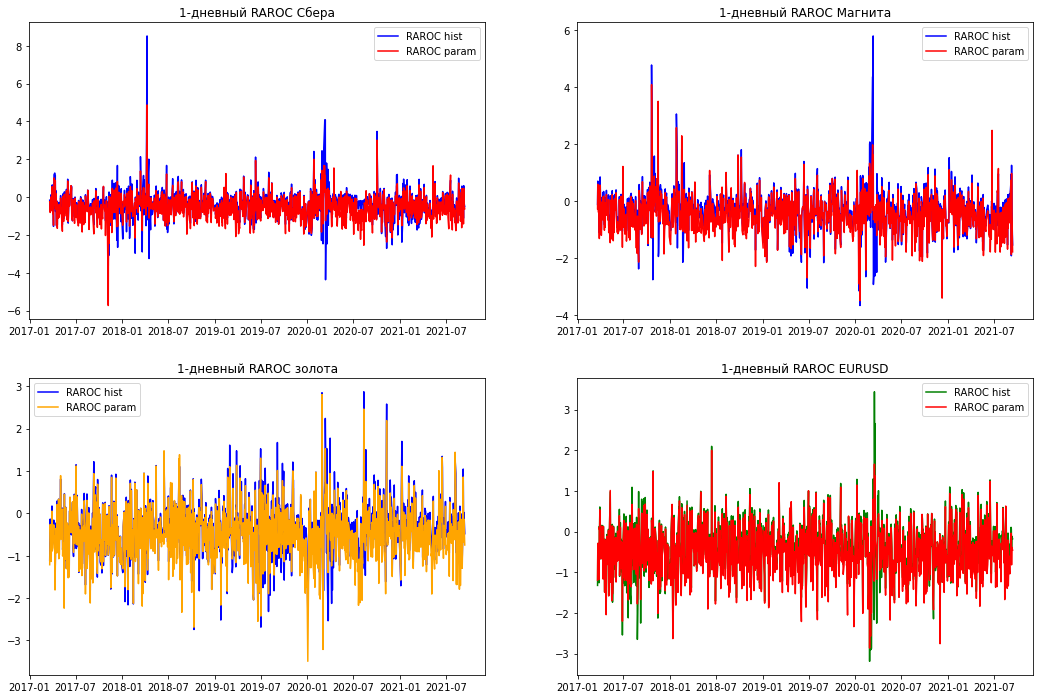

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax[0,0].plot(r.sber_raroc_hist, color='blue', label='RAROC hist')
ax[0,0].plot(r.sber_raroc_param, color='red', label='RAROC param')
ax[0,0].set_title('1-дневный RAROC Сбера')
ax[0,0].legend()

ax[0,1].plot(r.mgnt_raroc_hist, color='blue', label='RAROC hist')
ax[0,1].plot(r.mgnt_raroc_param, color='red', label='RAROC param')
ax[0,1].set_title('1-дневный RAROC Магнита')
ax[0,1].legend()

ax[1,0].plot(r.gold_raroc_hist, color='blue', label='RAROC hist')
ax[1,0].plot(r.gold_raroc_param, color='orange', label='RAROC param')
ax[1,0].set_title('1-дневный RAROC золота')
ax[1,0].legend()

ax[1,1].plot(r.eurusd_raroc_hist, color='green', label='RAROC hist')
ax[1,1].plot(r.eurusd_raroc_param, color='red', label='RAROC param')
ax[1,1].set_title('1-дневный RAROC EURUSD')
ax[1,1].legend()

plt.show();

На всякий случай сохраним результаты расчетов в файл.

In [65]:
r.to_csv('risk_metrics.csv')